In [1]:
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy import units
from astropy import constants

# Plot defaults and quantity supportS
from astropy.visualization import quantity_support
quantity_support();

In [7]:
class Atom:
    """
    Reads atomic data, calculates level populations according to Boltzmann's law,
    and ionisation fractions according to Saha's law.
    """
    
    def __init__(self, atomfile=None):
        """
        Parameters
        ----------
        atomfile : string, optional
            Name of file with atomic data. If not present, atomic data needs
            to be loaded with the .read_atom method.
        """
        self.loaded = False
        if atomfile:
            self.read_atom(atomfile)
        
    def read_atom(self, filename):
        """
        Reads atom structure from text file.
        
        Parameters
        ----------
        filename: string
            Name of file with atomic data.
        """
        tmp = numpy.loadtxt(filename, unpack=True)
        self.n_stages = int(tmp[2].max()) + 1
        # Get maximum number of levels in any stage
        self.max_levels = 0
        for i in range(self.n_stages):
            self.max_levels = max(self.max_levels, (tmp[2] == i).sum())
        # Populate level energies and statistical weights
        # Use a square array filled with NaNs for non-existing levels
        chi = numpy.empty((self.n_stages, self.max_levels))
        chi.fill(numpy.nan)
        self.g = numpy.copy(chi)
        for i in range(self.n_stages):
            nlevels = (tmp[2] == i).sum()
            chi[i, :nlevels] = tmp[0][tmp[2] == i]
            self.g[i, :nlevels] = tmp[1][tmp[2] == i]
        # Put units, convert from cm-1 to Joule
        chi = (chi / units.cm).to('aJ', equivalencies=units.spectral())
        # Save ionisation energies, saved as energy of first level in each stage
        self.chi_ion = chi[:, 0].copy()
        # Save level energies relative to ground level in each stage
        self.chi = chi - self.chi_ion[:, numpy.newaxis]
        self.loaded = True
        
    def compute_partition_function(self, temperature):
        """
        Computes partition functions using the atomic level energies and
        statistical weights.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        """
        temp = temperature[numpy.newaxis, numpy.newaxis]
        result = numpy.nansum(
            self.g[..., numpy.newaxis] * 
            numpy.exp(-self.chi[..., numpy.newaxis]/constants.k_B / temp),
            axis=1
        )
        return result
    
    def compute_excitation(self, temperature):
        """
        Computes the level populations relative to the ground state,
        according to the Boltzmann law.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        """
        pfunc = self.compute_partition_function(temperature)
        # reshape arrays to allow broadcast
        temp = temperature[numpy.newaxis, numpy.newaxis]
        g_ratio = self.g[..., numpy.newaxis] / pfunc[:, numpy.newaxis]
        chi = self.chi[..., numpy.newaxis]
        return g_ratio * numpy.exp(-chi / constants.k_B / temp)
       
    def compute_ionisation(self, temperature, electron_pressure):
        """
        Computes ionisation fractions according to the Saha law.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        N_e = electron_pressure / (constants.k_B * temperature)
        pfunc = self.compute_partition_function(temperature)
        saha_const = ((2 * numpy.pi * constants.m_e * constants.k_B * temperature) / (constants.h**2))**(3/2)
        nstage = numpy.zeros_like(pfunc) / units.m**3
        nstage[0] = 1. / units.m**3
        for r in range(self.n_stages -1):
            nstage[r + 1] = (nstage[r] / N_e * 2 * saha_const * pfunc[r + 1] / pfunc[r] 
                             * numpy.exp(-self.chi_ion[r + 1, numpy.newaxis] / (constants.k_B * temperature[numpy.newaxis])))
        
        # nansum is needed because the last stage may have only one level
        # (e.g. only ionisation potential)
        return nstage / numpy.nansum(nstage, axis=0) # get number of

    def compute_populations(self, temperature, electron_pressure):
        """
        Computes relative level populations for all levels and all
        ionisation stages using the Bolzmann and Saha laws.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (scalar or array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        return (self.compute_excitation(temperature) * self.compute_ionisation(temperature, electron_pressure)[:, numpy.newaxis])

    def plot_payne(self, temperature, electron_pressure):
        """
        Plots the Payne curves for the current atom.
        
        Parameters
        ----------
        temperature: astropy.units.quantity (array)
            Gas temperature in units of K or equivalent.
        electron_pressure: astropy.units.quantity (scalar)
            Electron pressure in units of Pa or equivalent.
        """
        # calculate population (relative) for a given temperature and pressure
        pops = self.compute_populations(temperature, electron_pressure)
        fig, ax = plt.subplots()
        ax.plot(numpy.tile(temperature, (self.n_stages, 1)).T, pops[:, 0].T, "b-") # temp vs pop of ground state of all ionization stages
        n_levels = self.chi.shape[1] # number of levels
        
        if n_levels > 1:
            ax.plot(numpy.tile(temperature, (self.n_stages, 1)).T, pops[:, 1].T, "r--") # temp vs first ionization state, second etc.
        if n_levels > 2:
            ax.plot(numpy.tile(temperature, (self.n_stages, 1)).T, pops[:, 2].T, "k:")
        ax.set_yscale("log")
        ax.set_ylim(1e-6, 1.1)
        ax.set_xlabel("Temperature (K)")
        ax.set_ylabel("Populations")

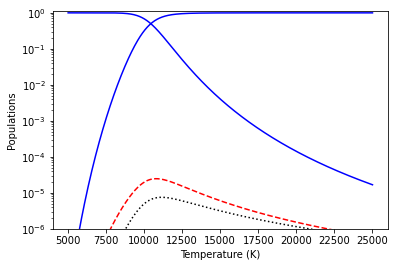

In [10]:
h_atom = Atom("H_atom.txt")

temp = numpy.linspace(5000, 25000, 500) * units.K
h_atom.plot_payne(temp, 100 * units.Pa)

# The first blue line is the neutral hydrogen, the second one is the ionized hydrogen
# Almost all hydrogen after 10000 is ionized because population is 1.
# More hydrogen in the first and second excited stage, goes down again because so much hydrogen is ionized, the neutral hydrogen
# starts to decrease. n=2 always below n=1.

In [11]:
# the lower level = the ground level: resonnance lines. Spectral lines are proportional to ...
# tasks: compute wavelengths of the first four Lyman lines and the first three Balmer lines

In [21]:
h_atom.chi[0] # Energy of neutral hydrogen 
((constants.h * constants.c) / h_atom.chi[0]).to("nm")

<Quantity [         inf, 121.56841096, 102.57334048,  97.25472664,
            94.97532294] nm>

In [25]:
h_atom.chi[0].to("nm", equivalencies=units.spectral()) # First one is hydrogen alpha

<Quantity [         inf, 121.56841096, 102.57334048,  97.25472664,
            94.97532294] nm>

In [26]:
# For Balmer lines:
h_atom.chi[0][1:] # subtract n=2, 1.6340

<Quantity [1.63401482, 1.93661028, 2.04251858, 2.09153893] aJ>

In [31]:
(h_atom.chi[0][2:] - h_atom.chi[0, 1]).to("nm", equivalencies=units.spectral()) # subtracting the first excited state
# H alpha, H beta, H delta 
# Difference from measurement in vacuum and air, from the database we get values in vacuum. We will only ose vacuum in this course

<Quantity [656.46916223, 486.27359065, 434.17293551] nm>

In [42]:
# Compute the approximate strength ratio of lyman alpha / balmer alpha
# use 100 Pa, and 
# temp = 5000 - 8000 K
pops = h_atom.compute_populations(5000 * units.K, 100 * units.Pa)
strength_L = pops[0, 0]
strength_B = pops[0, 1]

# shape of strength (2, 5, 1)
strength_L / strength_B
# The strength of a spectral line is prop. to population in the lower level

<Quantity [4.7620688e+09]>

In [43]:
# Exercise Calsium

Ca_atom = Atom("Ca_atom.txt")

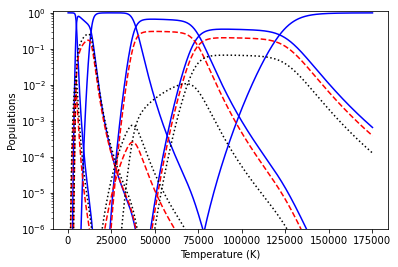

In [56]:
temp = numpy.linspace(100, 175_000, 500) * units.K
Ca_atom.plot_payne(temp, 100 * units.Pa)

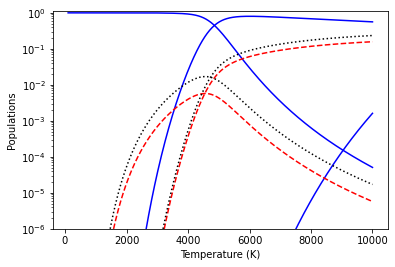

In [58]:
temp = numpy.linspace(100, 10_000, 500) * units.K
Ca_atom.plot_payne(temp, 100 * units.Pa)

In [ ]:
# In the Sun, N_Ca / N_H approx 2 * 10^-6. Why is Ca II H (resonnance line) stronger than H alpha? Use P_e = 100 dyne / cm^2.

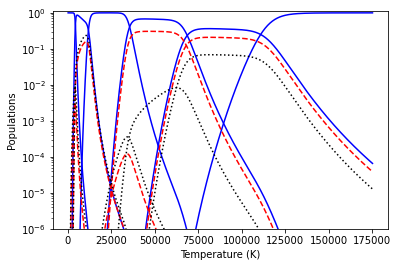

In [51]:
Ca_atom.plot_payne(temp, 100 * units.dyne/units.cm**2)

In [55]:
(100 * units.dyne/units.cm**2).si

<Quantity 10. N / m2>

In [60]:
temp = numpy.linspace(1000, 20_000, 100) * units.K
epress = (100 * units.dyne / units.cm**2)

h_pops = h_atom.compute_populations(temp, epress)
ca_pops = Ca_atom.compute_populations(temp, epress)

In [62]:
ca_abund = 2e-6
# Ca II K comes from ground state, first ionisation
# H alpha comes from first excited level, neutral atom
ca_h_ratio = ca_pops[1, 0] / h_pops[0, 1] * ca_abund

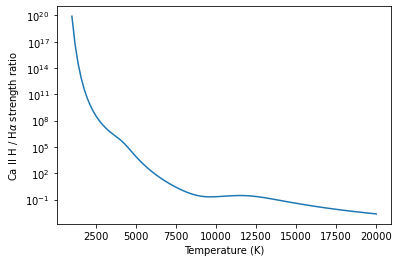

In [64]:
fig, ax = plt.subplots()
ax.plot(temp, ca_h_ratio)
ax.set_yscale("log")
ax.set_xlabel("Temperature (K)")
ax.set_ylabel(r"Ca II H / H$\alpha$ strength ratio");

# Since Ca II H is a resonnance line and H alpha is not. That is why it is stronger.

# This code is from tuesday lecture:

In [9]:
h_atom = Atom("H_atom.txt")

In [ ]:
h_atom.g

In [ ]:
h_atom.chi #automatically subtracted the ionization energy

In [ ]:
h_atom.chi_ion # ionization energy

In [ ]:
h_atom.compute_partition_function(5000 * units.K)

In [ ]:
# 1 is the statistical weight of ionized hydrogen, at 5000 K most of them are still in the ground level

In [ ]:
h_atom.compute_partition_function(10000 * units.K)

In [ ]:
h_atom.compute_partition_function(100000 * units.K)

In [ ]:
h_atom.compute_partition_function(6000 * units.K)

In [ ]:
temp = units.Quantity([5000, 15000], unit="K")

h_atom.compute_partition_function(temp)

In [ ]:
h_atom.compute_excitation(5000 * units.K).shape

In [ ]:
# 2=number of ionizations tages, 5 = max number of levels in each stage, 1 = number of ...

In [ ]:
h_atom.compute_excitation(5000 * units.K).value

In [ ]:
h_atom.compute_excitation(6000 * units.K).value

In [ ]:
h_atom.compute_excitation(25000 * units.K).value

In [ ]:
h_atom.compute_ionisation(6000 * units.K, 100 * units.Pa)

In [ ]:
# We see that most of hydrogen is in neutral form
h_atom.compute_ionisation(10000 * units.K, 100 * units.Pa)

In [ ]:
# expected smth else, change the pressure:

In [ ]:
h_atom.compute_ionisation(10000 * units.K, 50 * units.Pa)

In [ ]:
h_atom.compute_populations(8000 * units.K, 100 * units.Pa).value